In [3]:
# Import packages
import numpy as np
from pandas.plotting import register_matplotlib_converters
import sys
sys.path.insert(0, "../../../")
register_matplotlib_converters()
import scipy


# Import modules from dynamic neural network
from dynamic_neural_networks.utils import *
from dynamic_neural_networks.transformations.helper_functions import *
from dynamic_neural_networks.transformations.sorted_real_schur_forms import *
from dynamic_neural_networks.model.dnn import *
from dynamic_neural_networks.model.state_space_model import *
from dynamic_neural_networks.utils.helper_functions import *
from dynamic_neural_networks.data.diffusion_equation_2d import *
from sklearn.metrics import root_mean_squared_error

expensive_asserts = False

In [4]:
# Load the .mat file
data_path = '../../data/adam_sys_id' 
A = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data_500.mat')['A'])
B = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data_500.mat')['B'])
C = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data_500.mat')['C'])
timesteps = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data_500.mat')['t'])[0]
u_test = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data_500.mat')['u'])
y_test = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data_500.mat')['y'])

In [5]:
print(np.shape(A), np.shape(B), np.shape(C))
print(np.shape(u_test))
print(np.shape(timesteps))

(10, 10) (10, 10) (10, 10)
(500, 10)
(500,)


In [6]:
# Problem setup
# Dimensions of the LTI system
# Dimensions of the LTI system
d_in = 10  # Input dimension  (<-> Source term: Heat source/sink at grid points)
d_state = 10  # State dimension  (<-> Temperature)
d_out = 10  # Output dimension (<-> Temperature (state = output))
ssm_dim = [d_state, d_in, d_out]  # Dimensions of the state-space model


# Set initial state
x_0 = np.zeros((d_state,))

# Timesteps
D = np.zeros((d_out, d_in)) 
ssm = state_space_model(A, B, C, D)

# Method to interpolate the input function within each time-step
u_interp = "piecewise_linear"  # 'piecewise_constant', 'piecewise_linear', 'sample'

# Set u(t)
u = u_test

# Compute u'(t) using first-order finite differences
du_dt = np.zeros((len(timesteps), d_in))
for i in range(0, d_in):
    du_dt[i] = (u[i + 1] - u[i]) / (timesteps[i + 1] - timesteps[i])
inputs = [u, du_dt]

In [7]:
# Dynamic Neural Network Parameters
n_clusters = 4 # Number of clusters of close eigenvalues
outer_loop = "timesteps"  # 'neurons', 'timesteps'
ode_solver_rel_tol = 1e-10  # relative tolerance for ODE solver
ode_solver_abs_tol = 1e-10  # absolute tolerance for ODE solver
clustering_alg = KMeans(
    n_clusters=n_clusters, random_state=0, n_init="auto"
)  # Clustering algorithm
params = forward_pass_parameters(
    outer_loop=outer_loop,
    ssm_input_interpolation=u_interp,
    solver_routine="solve_ivp",
    ode_solver_params=ode_solver_parameters(
        atol=ode_solver_abs_tol, rtol=ode_solver_rel_tol, ode_solver="DOP853"
    ),
)  # Parameters concerning forward pass of a DyNN

c:\Users\chinm\miniconda3\envs\dynn\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\chinm\miniconda3\envs\dynn\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\chinm\miniconda3\envs\dynn\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chinm\miniconda3\envs\dynn\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\chinm\miniconda3\envs\dynn\Lib\subprocess.py", line 1538, in 

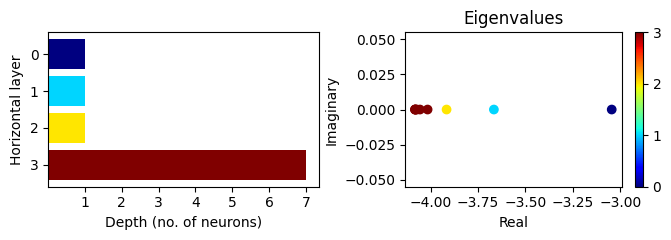

Condition number of the transformation matrix =  2599.9743946341205


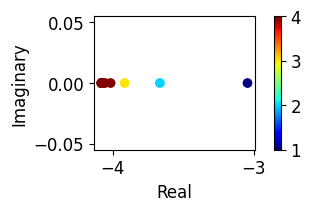

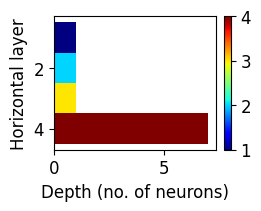

In [8]:
# Initialize the dynamic neural network
dynn = dynamic_neural_network(ssm=ssm)

# Simulate the LTI system using a dynamic neural network
dynn.fit(clustering_alg, verbose=0, show_plots=True, init_cond=x_0)

# Condition number of the transformation matrix
print("Condition number of the transformation matrix = ", dynn.cond_num)

# Plot eigenvalue clusters and DyNN architecture
dynn.plot_architecture(figname="sys_id", fig_size_1=(3, 2), fig_size_2=(2.5, 2), fontsize = 12, color_bar=True, sort_evals=False)

In [9]:
# Perform forward pass and compute output
y_dynn = dynn.predict(inputs, timesteps, params)


In [10]:
# Simulate the LTI system using python routine solve_ivp
y_solve_ivp, nfe_solver = numerical_simulation_ivp_solve(
    ssm,
    inputs,
    timesteps,
    u_interp,
    outer_loop,
    rtol=ode_solver_rel_tol,
    atol=ode_solver_abs_tol,
    init_cond=x_0
)

In [11]:
# Error compared to the numerical solver
abs_err_solve_ivp = abs(y_dynn - y_solve_ivp)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_solve_ivp))

abs_err_true = abs(y_dynn - y_test)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_true))

print( np.sqrt(np.sum(np.power((y_dynn - y_test),2))))


print(root_mean_squared_error(y_dynn, y_test))

Max absolute error (DyNN and solver:solve_ivp) : 1.9984014443252818e-15
Max absolute error (DyNN and solver:solve_ivp) : 0.02481416300428372
0.10881929178014838
0.0014960365966681963


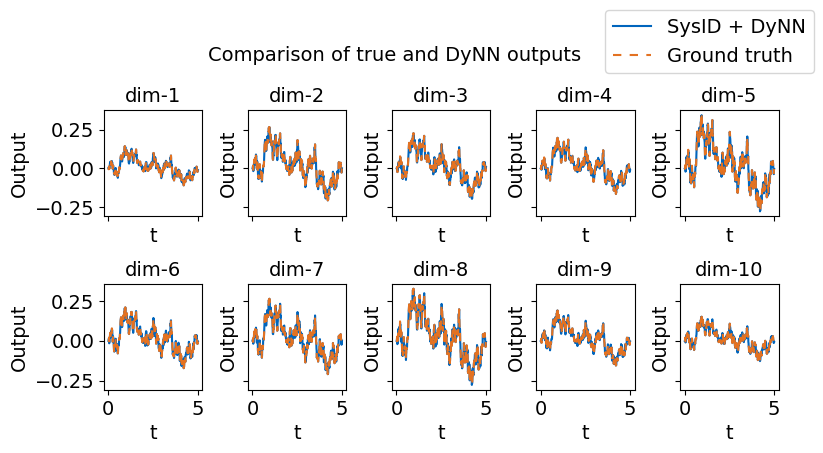

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fontsize=14
fig, axes = plt.subplots(2, 5, figsize=(8, 4.2), sharex='col', sharey='row')

# Loop through the axes and plot data
for i, ax in enumerate(axes.flat):
    ax.plot(timesteps, y_dynn[:, i], label='SysID + DyNN', color="#0065bd")
    ax.plot(timesteps, y_test[:, i],  label='Ground truth', 
            color="#e37222", linestyle='--', dashes=(4,4))
    ax.set_title(f"dim-{i+1}", fontsize = fontsize) 
    ax.set_ylabel(f"Output", fontsize = fontsize)
    ax.set_xlabel('t', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=1, 
        bbox_to_anchor=(0.75, 1.09), fontsize=fontsize)

plt.suptitle("Comparison of true and DyNN outputs", fontsize=fontsize)
fig.tight_layout()
plt.savefig('sys_id_dynn.png')
plt.show()
